In [1]:
from os import path
from pathlib import Path
from torch.utils.data import Dataset
import ujson
from torchvision.io import read_image
from datasets import load_dataset
import torch

dataset = load_dataset("Francesco/open-omniparser-dataset", cache_dir="data/")

if "validation" not in dataset:
    split = dataset["train"].train_test_split(0.10, seed=1337)
    dataset["train"] = split["train"]
    dataset["validation"] = split["test"]

In [2]:
dataset["train"][0]

{'image_id': 404,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x800>,
 'width': 1280,
 'height': 800,
 'objects': {'id': [10897,
   10898,
   10899,
   10900,
   10901,
   10902,
   10903,
   10904,
   10905,
   10906,
   10907,
   10908,
   10909,
   10910,
   10911,
   10912,
   10913,
   10914,
   10915,
   10916,
   10917,
   10918,
   10919,
   10920,
   10921,
   10922,
   10923,
   10924,
   10925,
   10926,
   10927,
   10928,
   10929,
   10930,
   10931,
   10932],
  'area': [3136.0,
   6250.0,
   962.25,
   962.25,
   1563.5,
   962.25,
   841.875,
   841.875,
   601.375,
   601.375,
   841.875,
   2946.5625,
   1792.0,
   1511.54296875,
   1343.84765625,
   3373.046875,
   1601.71875,
   1418.37890625,
   1357.734375,
   984.7265625,
   1150.3125,
   1535.625,
   1629.4921875,
   1076.66015625,
   2166.85546875,
   1773.10546875,
   1145.0390625,
   7728.73828125,
   8662.640625,
   1218.8671875,
   3049.7265625,
   4440.44921875,
   1629.66796875,
 

In [3]:
from torchvision import tv_tensors


class OmniparserDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        image_id = sample["image_id"]
        image = sample["image"]
        boxes = sample["objects"]["bbox"]
        categories = sample["objects"]["category"]

        class_labels = torch.tensor(categories, dtype=torch.int64)
        iscrowd = torch.zeros_like(class_labels)
        if len(boxes) == 0:
            boxes = torch.empty((0, 4), dtype=torch.float16)
        if self.transform:
            boxes = tv_tensors.BoundingBoxes(
                boxes,
                format="XYWH",
                canvas_size=(sample["height"], sample["width"]),
                dtype=torch.float16,
            )
            transformed = self.transform(image, boxes, class_labels)
            image, boxes, class_labels = transformed
        if isinstance(boxes, tv_tensors.BoundingBoxes):
            boxes = boxes.data
        else:
            boxes = torch.tensor(boxes, dtype=torch.float16)
        # fuck hf not telling they need fucking Yolo piece of shit fucking shit format
        boxes[:, 0] = boxes[:, 0] + boxes[:, 2] / 2
        boxes[:, 1] = boxes[:, 1] + boxes[:, 3] / 2

        _, height, width = image.shape
        boxes = boxes / torch.tensor([width, height, width, height])
        area = boxes[:, 2] * boxes[:, 3]
        size = torch.tensor([height, width])

        labels = {
            "class_labels": class_labels,
            "boxes": boxes,
            "area": area,
            "size": size,
            "iscrowd": iscrowd,
            "image_id": torch.tensor([image_id]),
        }

        return {"pixel_values": image, "labels": labels}

In [22]:
from torchvision.transforms import v2
from torchvision import tv_tensors
import torch

width, height = 800, 640

train_transform = v2.Compose(
    [
        v2.ToImage(),
        # v2.RandomCrop(size=(720, 1152)),  # ~10% crop from 1280x800
        v2.RandomHorizontalFlip(p=0.25),
        v2.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.05, hue=0.02),
        v2.Resize(size=(height, width), antialias=True),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size=(height, width), antialias=True),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [6]:
train_dataset = OmniparserDataset(
    dataset["train"],
    train_transform,
)
validation_dataset = OmniparserDataset(
    dataset["validation"],
    val_transform,
)
test_dataset = OmniparserDataset(
    dataset["test"],
    val_transform,
)
train_dataset[15]["labels"]

NameError: name 'OmniparserDataset' is not defined

In [9]:
import numpy as np
from PIL import Image, ImageDraw

categories = dataset["train"].features["objects"].feature["category"].names
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

# for i in [15, 16]:
#     sample = train_dataset[i]

#     # De-normalize image
#     image = sample["pixel_values"]
#     print("Image tensor shape:", image.shape)
#     image = image.numpy().transpose(1, 2, 0)
#     image = (image - image.min()) / (image.max() - image.min()) * 255.0
#     image = Image.fromarray(image.astype(np.uint8))

#     # Convert boxes from [center_x, center_y, width, height] to [x, y, width, height] for visualization
#     boxes = sample["labels"]["boxes"].numpy()
#     print("Boxes shape:", boxes.shape)
#     boxes[:, :2] = boxes[:, :2] - boxes[:, 2:] / 2
#     w, h = image.size
#     boxes = boxes * np.array([w, h, w, h])[None]

#     categories = sample["labels"]["class_labels"].numpy()
#     print("Categories shape:", categories.shape)

#     # Draw boxes and labels on image
#     draw = ImageDraw.Draw(image)
#     for box, category in zip(boxes, categories):
#         x, y, w, h = box
#         draw.rectangle([x, y, x + w, y + h], outline="red", width=1)
#         draw.text((x, y), id2label[category], fill="white")

#     display(image)

In [7]:
import torch


def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

In [10]:
import numpy as np
from dataclasses import dataclass
from transformers.image_transforms import center_to_corners_format
from torchmetrics.detection.mean_ap import MeanAveragePrecision

checkpoint = "ustc-community/dfine-medium-obj365"

from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(
    checkpoint,
    do_resize=True,
    size={"width": width, "height": height},
    use_fast=True,
)


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, size in zip(target_batch, image_size_batch):

                # here we have "yolo" format (x_center, y_center, width, height) in relative coordinates 0..1
                # and we need to convert it to "pascal" format (x_min, y_min, x_max, y_max) in absolute coordinates
                height, width = size
                boxes = torch.tensor(target["boxes"])
                boxes = center_to_corners_format(boxes)
                boxes = boxes * torch.tensor([[width, height, width, height]])

                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(
                logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes)
            )
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):
        predictions, targets = (
            evaluation_results.predictions,
            evaluation_results.label_ids,
        )

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")

        # Fix: Handle the case where classes might be 0-dimensional (single class)
        if classes.dim() == 0:
            # Single class case
            classes = classes.unsqueeze(0)
            map_per_class = map_per_class.unsqueeze(0)
            mar_100_per_class = mar_100_per_class.unsqueeze(0)

        for class_id, class_map, class_mar in zip(
            classes, map_per_class, mar_100_per_class
        ):
            class_name = (
                self.id2label[class_id.item()]
                if self.id2label is not None
                else class_id.item()
            )
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics


eval_compute_metrics_fn = MAPEvaluator(
    image_processor=image_processor, threshold=0.01, id2label=id2label
)

In [9]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DFineForObjectDetection were not initialized from the model checkpoint at ustc-community/dfine-medium-obj365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([366]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([366, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([366]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([366, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([366]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([366, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated

In [10]:
from comet_ml import start
from comet_ml.integration.pytorch import log_model

experiment = start(
    api_key="I1nY3jSiNB8ob2ETxF1APyRDR",
    project_name="omni-parser",
    workspace="francesco-zuppichini",
)

experiment.log_parameters({
    "image_width": width,
    "image_height": height})

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/francesco-zuppichini/omni-parser/f52afed7293c40da9057283f48d8285c



In [ ]:
from transformers import TrainingArguments


model_slug = f"{checkpoint.split("/")[-1]}-{width}x{height}"
training_args = TrainingArguments(
    output_dir=model_slug,
    fp16=True,
    num_train_epochs=50,
    max_grad_norm=1.0,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_steps=100,
    per_device_train_batch_size=16,
    dataloader_num_workers=8,
    lr_scheduler_type="cosine",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=10,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    report_to="comet_ml",
    logging_steps=50,
    logging_strategy="steps",
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

COMET INFO: An experiment with the same configuration options is already running and will be reused.


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Interactive Elemenet,Mar 100 Interactive Elemenet
1,50.303200,4.636323,0.003400,0.006800,0.003200,0.001600,0.005300,0.009200,0.003500,0.012300,0.038900,0.033000,0.041700,0.046200,0.003400,0.038900
2,35.763200,3.540157,0.008900,0.019200,0.007900,0.004200,0.016100,0.008000,0.004200,0.019900,0.072900,0.056300,0.078500,0.101900,0.008900,0.072900
3,31.060900,3.020131,0.015200,0.034600,0.011300,0.012400,0.020600,0.007600,0.004600,0.031900,0.114700,0.103500,0.116500,0.145600,0.015200,0.114700
4,29.332800,2.846046,0.034600,0.070000,0.032500,0.034800,0.038800,0.020000,0.008700,0.053600,0.158000,0.153800,0.157300,0.177700,0.034600,0.158000
5,28.057600,2.812307,0.035500,0.077500,0.031500,0.039400,0.047500,0.013800,0.009800,0.060300,0.172800,0.161800,0.173600,0.207600,0.035500,0.172800
6,27.359800,2.603563,0.060000,0.117900,0.055900,0.063100,0.066000,0.024600,0.014000,0.075000,0.201900,0.203500,0.199300,0.212200,0.060000,0.201900
7,26.330300,2.470507,0.078200,0.146400,0.072200,0.080200,0.086900,0.038200,0.014600,0.088500,0.235000,0.234100,0.227300,0.280200,0.078200,0.235000
8,25.873400,2.381440,0.090800,0.168500,0.085400,0.083500,0.111300,0.042100,0.015800,0.093100,0.261300,0.239200,0.264200,0.322700,0.090800,0.261300
9,25.444600,2.344710,0.108400,0.190500,0.101300,0.097600,0.127000,0.058200,0.018700,0.108100,0.284400,0.274800,0.286300,0.307800,0.108400,0.284400
10,25.370600,2.203053,0.124700,0.223600,0.113200,0.108600,0.149900,0.050600,0.020300,0.111800,0.319900,0.315600,0.325300,0.306800,0.124700,0.319900


TrainOutput(global_step=5050, training_loss=24.618950944655012, metrics={'train_runtime': 7179.2773, 'train_samples_per_second': 11.178, 'train_steps_per_second': 0.703, 'total_flos': 1.4378339075328e+19, 'train_loss': 24.618950944655012, 'epoch': 50.0})

In [4]:
import torch
import requests
from PIL import Image, ImageDraw
from transformers import AutoModelForObjectDetection
import ipywidgets as widgets
from IPython.display import display, clear_output

device = "cuda"

# Load model once
checkpoint = "/media/zuppif/Cancro/open-omniparser-dataset/omniparser/dfine-medium-obj365-800x640/checkpoint-5050"
print(f"Loading model from: {checkpoint}")

model = AutoModelForObjectDetection.from_pretrained(checkpoint).to(device)
print("Model loaded successfully!")

Loading model from: /media/zuppif/Cancro/open-omniparser-dataset/omniparser/dfine-medium-obj365-800x640/checkpoint-5050
Model loaded successfully!


Image 0 - Detections (threshold=0.4):
--------------------------------------------------
Detected interactive_elemenet with confidence 0.85 at location [1095.55, 15.03, 1208.26, 45.14]
Detected interactive_elemenet with confidence 0.581 at location [963.84, 20.91, 1025.6, 38.06]
Detected interactive_elemenet with confidence 0.519 at location [1222.19, 13.7, 1256.89, 47.05]
Detected interactive_elemenet with confidence 0.517 at location [506.11, 64.44, 694.88, 201.97]
Detected interactive_elemenet with confidence 0.482 at location [60.11, 330.01, 692.81, 542.45]
Detected interactive_elemenet with confidence 0.457 at location [506.01, 336.55, 694.74, 477.03]
Detected interactive_elemenet with confidence 0.445 at location [1040.56, 21.3, 1080.59, 38.7]
Detected interactive_elemenet with confidence 0.42 at location [725.7, 19.28, 770.7, 45.73]
Detected interactive_elemenet with confidence 0.404 at location [510.02, 17.2, 769.37, 49.34]


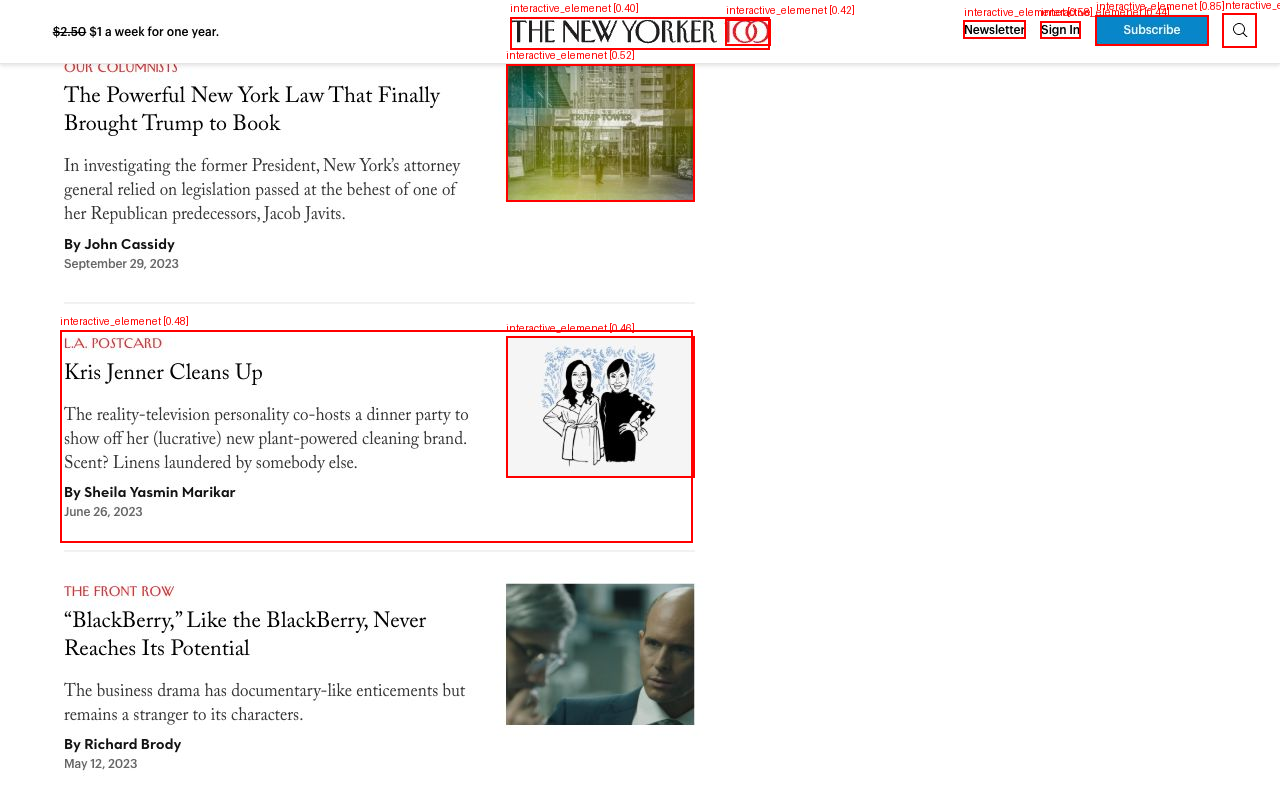

In [25]:
from PIL import Image

def visualize_detection(index=0, threshold=0.4):
    """
    Visualize object detection results for a given test dataset index
    """
    try:
        # Get image from dataset
        image = dataset["test"][index]["image"]
        # image = Image.open("test.png").convert('RGB')
        
        # Prepare inputs
        inputs = val_transform(image)
        inputs = inputs.to(device)
        
        # Run inference
        with torch.no_grad():
            outputs = model(pixel_values=inputs.unsqueeze(0))
        
        target_sizes = torch.tensor([image.size[::-1]])
        result = image_processor.post_process_object_detection(
            outputs, threshold=threshold, target_sizes=target_sizes
        )[0]
        
        # Print detection results
        print(f"Image {index} - Detections (threshold={threshold}):")
        print("-" * 50)
        
        if len(result["scores"]) == 0:
            print("No objects detected!")
        else:
            for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
                box = [round(i, 2) for i in box.tolist()]
                print(
                    f"Detected {model.config.id2label[label.item()]} with confidence "
                    f"{round(score.item(), 3)} at location {box}"
                )
        
        # Draw bounding boxes
        image_with_boxes = image.copy()
        draw = ImageDraw.Draw(image_with_boxes)
        
        for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
            box = [round(i, 2) for i in box.tolist()]
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=2)
            text_label = model.config.id2label[label.item()]
            draw.text((x, y-15), f"{text_label} [{score.item():.2f}]", fill="red")
        
        # Display the image
        display(image_with_boxes)
        
    except IndexError:
        print(f"Error: Index {index} is out of range. Dataset has {len(dataset['test'])} test images.")


# Test the function
visualize_detection(0)

In [26]:
# Create interactive widgets
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(dataset["test"])-1,
    step=1,
    description='Image Index:',
    style={'description_width': 'initial'}
)

threshold_slider = widgets.FloatSlider(
    value=0.4,
    min=0.1,
    max=1.0,
    step=0.01,
    description='Threshold:',
    style={'description_width': 'initial'}
)

# Create interactive interface
def interactive_detection(index, threshold):
    clear_output(wait=True)
    visualize_detection(index, threshold)

# Display the interactive widget
interactive_widget = widgets.interact(
    interactive_detection,
    index=index_slider,
    threshold=threshold_slider
)

interactive(children=(IntSlider(value=0, description='Image Index:', max=446, style=SliderStyle(description_wi…